# Homework 5
***

**Name**: Alex Ma

***

This assignment is due on Gradescope by **Friday March 14 at 5:00PM**. If you submit the assignment  by this deadline, you will receive 2 bonus points. If you need a little extra time, you may submit your work by **Monday March 17 at 5:00PM**. Your solutions to theoretical questions should be done in Markdown directly below the associated question.  Your solutions to computational questions should include any specified R code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- There are 3 total questions on this assignment. 
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Remember that there is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked here. **All** of your written commentary, justifications and mathematical work should be in Markdown.
- Because you can technically evaluate notebook cells in a non-linear order, it's a good idea to do Kernel $\rightarrow$ Restart & Run All as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 



---

## Problem 1 (15 points)

**PART A:** Prove that the adjusted $R^2$ is always less than $R^2$.

**Answer**

$$\begin{align*}
\textit{Adjusted } R^2 &= 1 - \frac{(1 - R^2)(n - 1)}{n - p - 1} \\
                        &= 1 - \left(1 - \left(1 - \frac{SSR}{SST}\right)\right)(\frac{n - 1}{n - p - 1}) \\
                        &= 1 - \left(1 - 1 + \frac{SSR}{SST}\right)(\frac{n - 1}{n - p - 1}) \\
                        &= \left(1 - \frac{SSR}{SST}\right)(\frac{n - 1}{n - p - 1}) \\
                        &= R^2 \cdot \frac{n - 1}{n - p - 1} \text{ assume $p \geq 1$, $p = $ number of features} \\
                        &< R^2
\end{align*}$$

## Problem 2 Comparing Model Selection Techniques (45 points)

Recall again, the Amazon book data. The data consists of data on $n = 325$ books and includes measurements of:

- `aprice`: The price listed on Amazon (dollars)


- `lprice`: The book's list price (dollars)


- `weight`: The book's weight (ounces)


- `pages`: The number of pages in the book


- `height`: The book's height (inches)


- `width`: The book's width (inches)


- `thick`: The thickness of the book (inches)


- `cover`: Whether the book is a hard cover of paperback.


- And other variables...

We'll explore various models to predict `aprice`. But first, we'll repeat the data cleaning from our lesson on t-tests. We'll also split the data into a training set and a test/validation set.

In [24]:
# You may either install the "car" package, or import the "vif_function.r" script
# in order to have a usable vif() function that will be needed later on in this problem.
# Uncomment the one that you need prior to executing this cell.

# install.packages("car")
install.packages("corrplot")
library(ggplot2)
# library(car) #for the vif() function
library(corrplot)
# source("vif_function.r")

amazon = read.csv(url(paste0("https://raw.githubusercontent.com/bzaharatos/",
                    "-Statistical-Modeling-for-Data-Science-Applications/",
                    "master/Modern%20Regression%20Analysis%20/Datasets/amazon.txt")), sep = "\t")
names(amazon)
df = data.frame(aprice = amazon$Amazon.Price, lprice = as.numeric(amazon$List.Price),  
                pages = amazon$NumPages, width = amazon$Width, weight = amazon$Weight..oz,  
                height = amazon$Height, thick = amazon$Thick, cover = amazon$Hard..Paper)

#cleaning the data, as was done in our lesson on t-tests
df$weight[which(is.na(df$weight))] = mean(df$weight, na.rm = TRUE)
df$pages[which(is.na(df$pages))] = mean(df$pages, na.rm = TRUE)
df$height[which(is.na(df$height))] = mean(df$height, na.rm = TRUE)
df$width[which(is.na(df$width))] = mean(df$width, na.rm = TRUE)
df$thick[which(is.na(df$thick))] = mean(df$thick, na.rm = TRUE)
df = df[-205,]

#training and test set
set.seed(11111)
n = floor(0.8 * nrow(df)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df)), size = n) #randomly sample indicies to be included in the training set

train = df[index, ] #set the training set to be the randomly sampled rows of the dataframe
test = df[-index, ] #set the testing set to be the remaining rows
cat("There are", dim(train)[1], "rows and",dim(train)[2],"columns in the training set. ")  #check the dimensions
cat("There are", dim(test)[1], "rows and",dim(test)[2],"columns in the testing set.")  #check the dimensions


Warning message:
"package 'corrplot' is in use and will not be installed"


[1] "Title"        "Author"       "List.Price"   "Amazon.Price" "Hard..Paper" 
 [6] "NumPages"     "Publisher"    "Pub.year"     "ISBN.10"      "Height"      
[11] "Width"        "Thick"        "Weight..oz."

There are 259 rows and 8 columns in the training set. There are 65 rows and 8 columns in the testing set.

Also, here are some pairwise correlations.

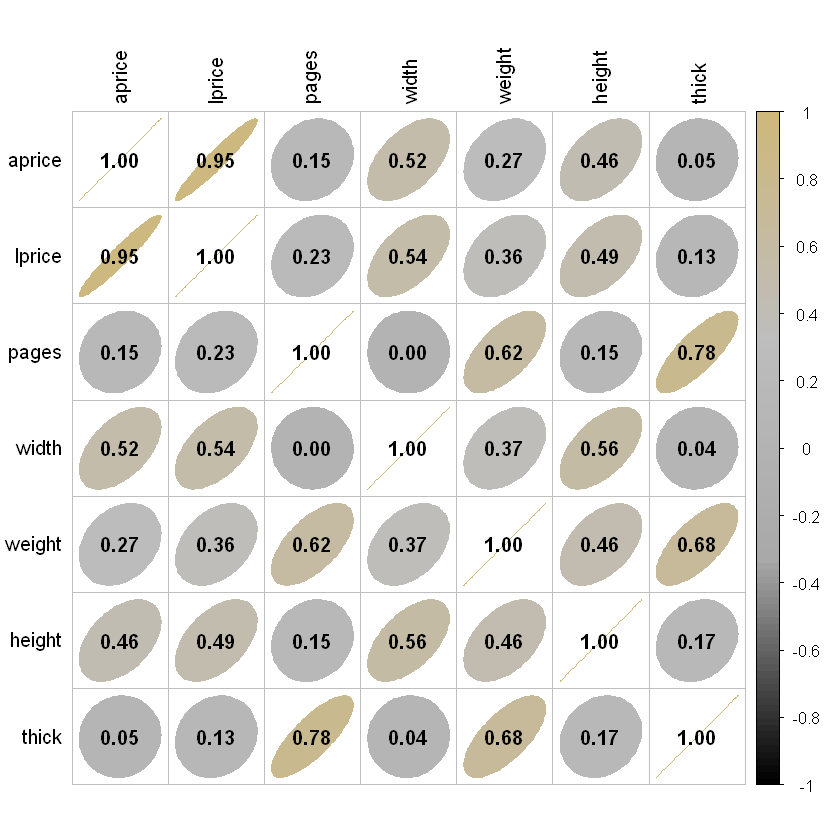

In [25]:
col4 = colorRampPalette(c("black", "darkgrey", "grey","#CFB87C"))
corrplot(cor(train[,-8]), method = "ellipse", col = col4(100),  addCoef.col = "black", tl.col = "black")

**PART A:** Fit a full model on the training dataset. Then, use the `update()` function to perform backward selection (let $\alpha_{crit} = 0.15$). At each step of backward selection, calculate the mean squared prediction error (MSPE) on the test set.

In [2]:
library(caret)
library(Metrics)

Loading required package: lattice


Attaching package: 'Metrics'


The following objects are masked from 'package:caret':

    precision, recall




In [86]:
X_train <- train[, c("lprice", "pages", "width", "weight", "height", "thick", "cover")]
y_train <- train$aprice
X_test <- test[, c("lprice", "pages", "width", "weight", "height", "thick", "cover")]
y_test <- test$aprice

# 1. Fit the full model (Linear regression in this case)
full_model <- lm(aprice ~ lprice + pages + width + weight + height + thick + cover, data = train)

# Initialize MSPE scores
mspe_scores <- c()

# 2. Perform backward selection using update() with alpha_critical = 0.15
current_model <- full_model
current_features <- names(X_train)

count <- 6
# Perform backward elimination until no more features have p-value > 0.15
while (count >= 0) {
    count <- count - 1
    # 2.1. Predict on the test set
    y_pred <- predict(current_model, newdata = X_test)
    
    # 2.2. Calculate MSPE
    mspe <- mse(y_test, y_pred)
    mspe_scores <- c(mspe_scores, mspe)
    
    # 2.3. Check the p-values of the current model
    p_values <- summary(current_model)$coefficients[, 4]
    p_values <- p_values[names(p_values) != "(Intercept)"]
    # Find features with p-value > alpha_critical = 0.15
    non_significant <- names(p_values)[p_values > 0.15]
    
    # If no feature has a p-value > alpha_critical, stop backward selection
    if (length(non_significant) == 0) {
        break
    }
    
    # 2.4. Update the model by removing the feature with the highest p-value
    # Remove the feature with the highest p-value (non-significant feature)
    feature_to_remove <- names(p_values)[which.max(p_values)]
    current_features <- setdiff(current_features, feature_to_remove)

    # Create the formula dynamically
    formula_dynamic <- as.formula(paste("aprice ~", paste(current_features, collapse = " + ")))
    
    # Fit the model with the updated formula
    current_model <- lm(formula_dynamic, data = train)
  
}

print(summary(current_model))

# Print the MSPE scores for each iteration
print("MSPE scores at each step of backward selection:")
print(mspe_scores)


Call:
lm(formula = formula_dynamic, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.5460  -1.7807  -0.4809   1.2698  20.7516 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.918942   0.809428  -2.371  0.01850 *  
lprice       0.873961   0.016858  51.843  < 2e-16 ***
pages       -0.003391   0.001935  -1.753  0.08084 .  
weight      -0.100753   0.051327  -1.963  0.05074 .  
coverP       1.606029   0.585836   2.741  0.00655 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.82 on 254 degrees of freedom
Multiple R-squared:  0.9198,	Adjusted R-squared:  0.9186 
F-statistic: 728.5 on 4 and 254 DF,  p-value: < 2.2e-16

[1] "MSPE scores at each step of backward selection:"
[1] 9.358554 9.229814 8.555423 8.109727


**PART B:** Check the standard diagnostic plots for this "best" model. Specifically, do you think this model satisfies the modeling assumptions?

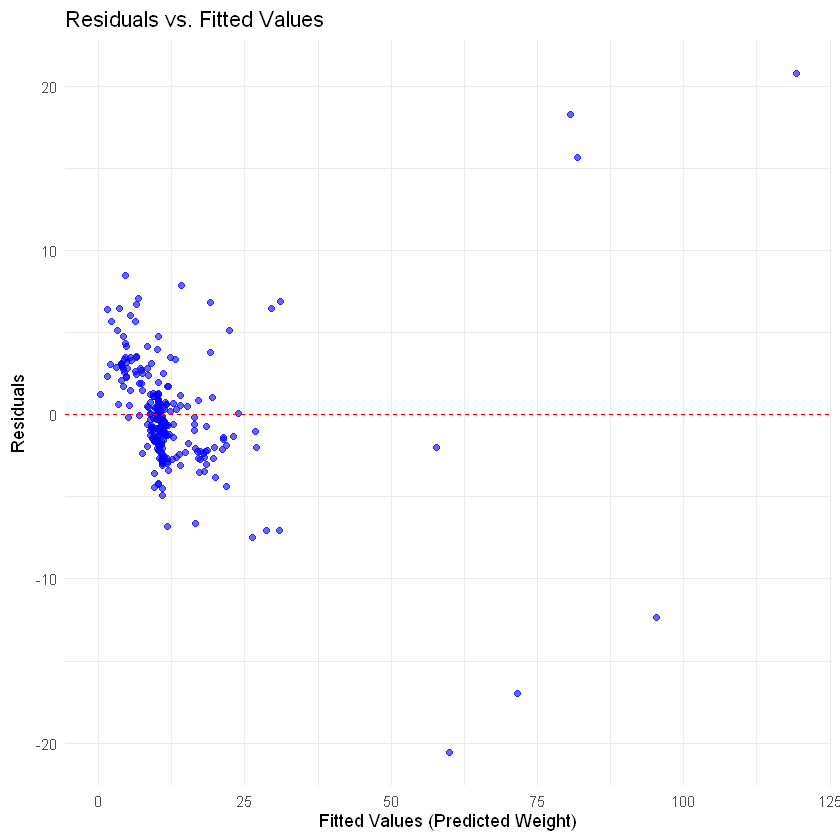

In [66]:
# Plot the residuals versus fitted values.
train$Fitted_Values <- fitted(current_model)  # Predicted values
train$Residuals <- residuals(current_model)

library(ggplot2)

ggplot(train, aes(x = Fitted_Values, y = Residuals)) +
  geom_point(color = "blue", alpha = 0.6) +  # Scatter plot of residuals
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +  # Reference line at y = 0
  labs(title = "Residuals vs. Fitted Values",
       x = "Fitted Values (Predicted Weight)",
       y = "Residuals") +
  theme_minimal()

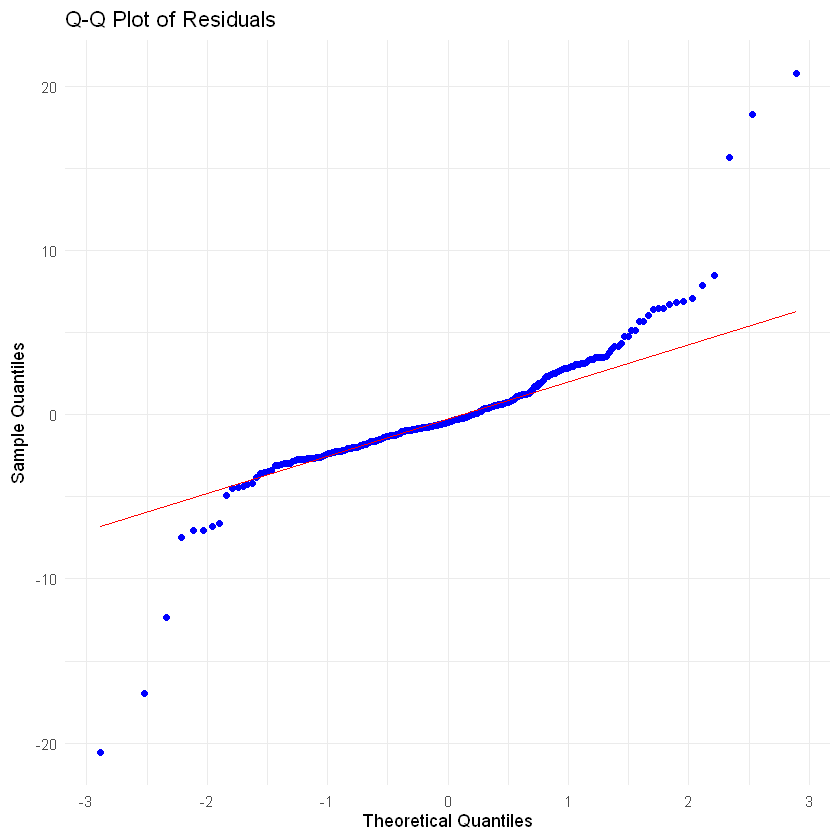

In [68]:
ggplot(data = train, aes(sample = residuals(current_model))) +
  stat_qq(color = "blue") +  # Q-Q plot points
  stat_qq_line(color = "red") +  # Reference normality line
  labs(title = "Q-Q Plot of Residuals",
       x = "Theoretical Quantiles",
       y = "Sample Quantiles") +
  theme_minimal()

The residual-fitted value plot shows some heteroscedasticity because there're some extreme outliers and the rest clusters around $y=0$. Besides, The Q-Q plot shows deviation from the central line in either ends of the plot. Thus this model doesn't satisfy all the modeling assumptions.

**PART C:** Compare the MSPE for each of the models you fit along the way as you performed the backward selection.  Using MSPE as a criterion, which model is best? 

**Answer**: The models have respectively 9.358554, 9.229814, 8.555423 and 8.109727 MSPE scores. Solely according to this, the first model is the best.

**PART D:** Now, compute the best model of size  1 , the best model of size  2 , etc. up through the best model of size 7  (the full model). Then, among the remaining  7  models, compute the best model according the AIC, BIC, and  𝑅2𝑎 . Do the criteria pick out different models? Which model do you think is best? Justify your answer.

In [69]:
install.packages("leaps")
library(leaps)

Installing package into 'C:/Users/inipo/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'leaps' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\inipo\AppData\Local\Temp\RtmpCGp8Uc\downloaded_packages


AIC chooses the model: $k=3$

        

BIC chooses the model: $k=4$

        

$R^2_a$ chooses the model: $k=4$

        

In [70]:
subset_model <- regsubsets(aprice ~ lprice + pages + width + weight + height + thick + cover,
                           data = df, 
                           nvmax = 7)  # Specifies max number of predictors

# View summary of the best models for each subset size
subset_summary <- summary(subset_model)
subset_summary

Subset selection object
Call: regsubsets.formula(aprice ~ lprice + pages + width + weight + 
    height + thick + cover, data = df, nvmax = 7)
7 Variables  (and intercept)
       Forced in Forced out
lprice     FALSE      FALSE
pages      FALSE      FALSE
width      FALSE      FALSE
weight     FALSE      FALSE
height     FALSE      FALSE
thick      FALSE      FALSE
coverP     FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: exhaustive
         lprice pages width weight height thick coverP
1  ( 1 ) "*"    " "   " "   " "    " "    " "   " "   
2  ( 1 ) "*"    " "   " "   " "    " "    "*"   " "   
3  ( 1 ) "*"    " "   " "   " "    " "    "*"   "*"   
4  ( 1 ) "*"    " "   " "   "*"    " "    "*"   "*"   
5  ( 1 ) "*"    " "   "*"   "*"    " "    "*"   "*"   
6  ( 1 ) "*"    "*"   "*"   "*"    " "    "*"   "*"   
7  ( 1 ) "*"    "*"   "*"   "*"    "*"    "*"   "*"   

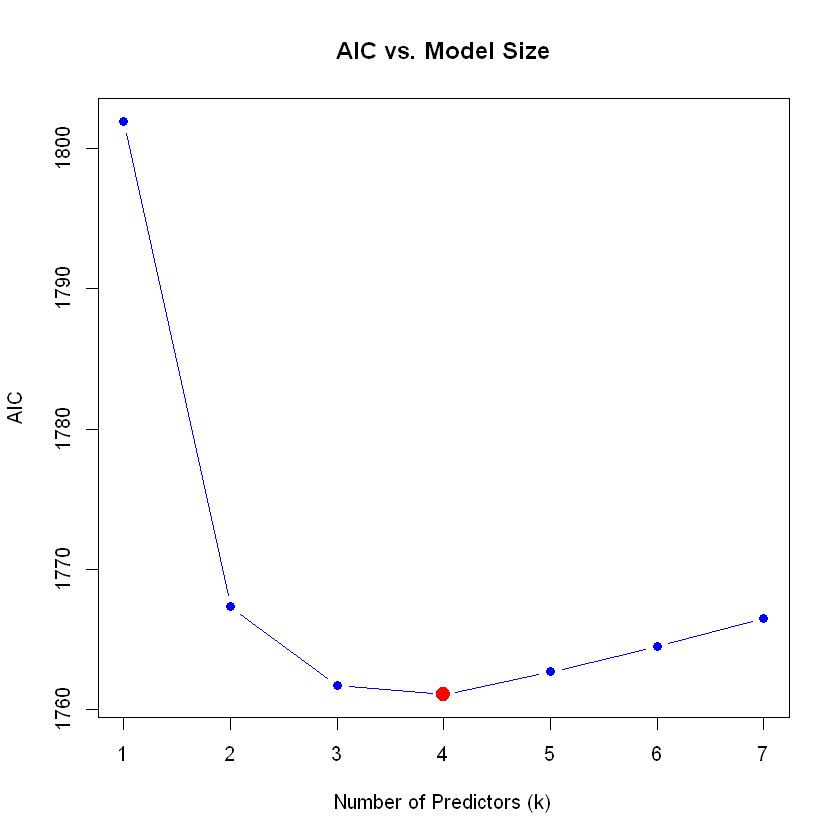

In [81]:
# 6) CODE HERE
# Initialize vector to store AIC values
aic_values <- numeric(7)  # Store AIC for each model size

# Loop through model sizes (k = 1 to 7)
for (k in 1:7) {
    # Extract selected predictors for the best model with k predictors
    selected_vars <- names(which(subset_summary$which[k, -1]))  # Exclude intercept
    selected_vars <- gsub("coverP", "cover", selected_vars)
    formula_str <- paste("aprice ~", paste(selected_vars, collapse = " + "))  # Build formula

    # Fit linear model with selected predictors
    model <- lm(as.formula(formula_str), data = df)
    
    # Compute AIC
    aic_values[k] <- AIC(model)
}

# Plot AIC vs. Model Size
plot(1:7, aic_values, type = "b", pch = 19, col = "blue", xlab = "Number of Predictors (k)", 
     ylab = "AIC", main = "AIC vs. Model Size")

# Highlight the best model (lowest AIC)
best_k <- which.min(aic_values)
points(best_k, aic_values[best_k], col = "red", pch = 19, cex = 1.5)  # Red dot for best model

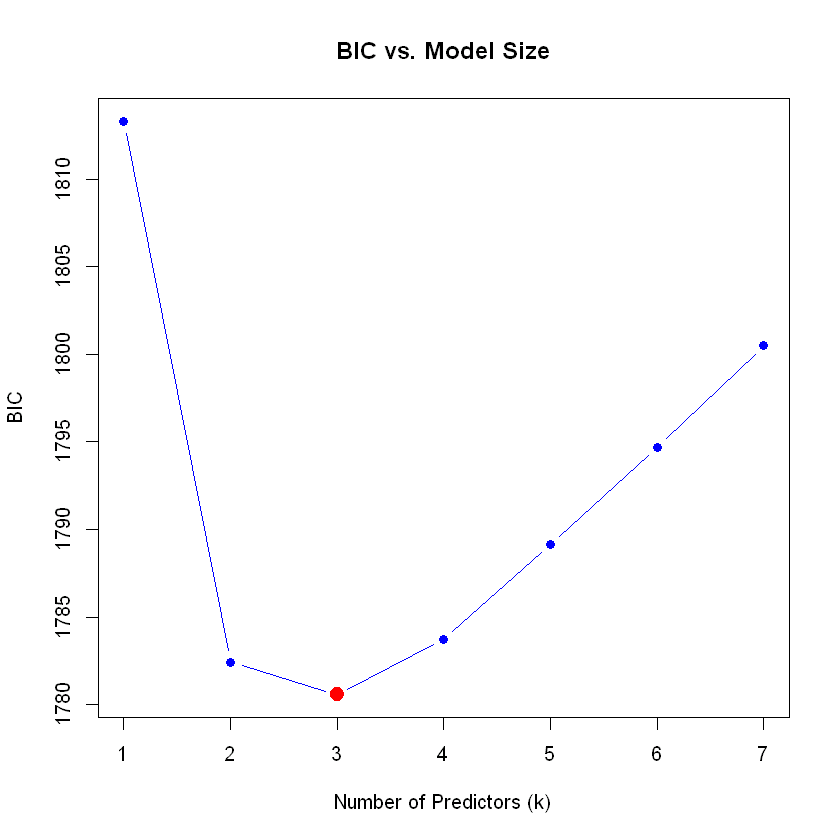

In [82]:
# 6) CODE HERE
# Initialize vector to store AIC values
bic_values <- numeric(7)  # Store AIC for each model size

# Loop through model sizes (k = 1 to 7)
for (k in 1:7) {
    # Extract selected predictors for the best model with k predictors
    selected_vars <- names(which(subset_summary$which[k, -1]))  # Exclude intercept
    selected_vars <- gsub("coverP", "cover", selected_vars)
    formula_str <- paste("aprice ~", paste(selected_vars, collapse = " + "))  # Build formula

    # Fit linear model with selected predictors
    model <- lm(as.formula(formula_str), data = df)
    
    # Compute BIC
    bic_values[k] <- BIC(model)
}

# Plot AIC vs. Model Size
plot(1:7, bic_values, type = "b", pch = 19, col = "blue", xlab = "Number of Predictors (k)", 
     ylab = "BIC", main = "BIC vs. Model Size")

# Highlight the best model (lowest AIC)
best_k <- which.min(bic_values)
points(best_k, bic_values[best_k], col = "red", pch = 19, cex = 1.5)  # Red dot for best model

(Intercept)      lprice       pages       width      weight      height 
       TRUE        TRUE       FALSE       FALSE        TRUE       FALSE 
      thick      coverP 
       TRUE        TRUE 


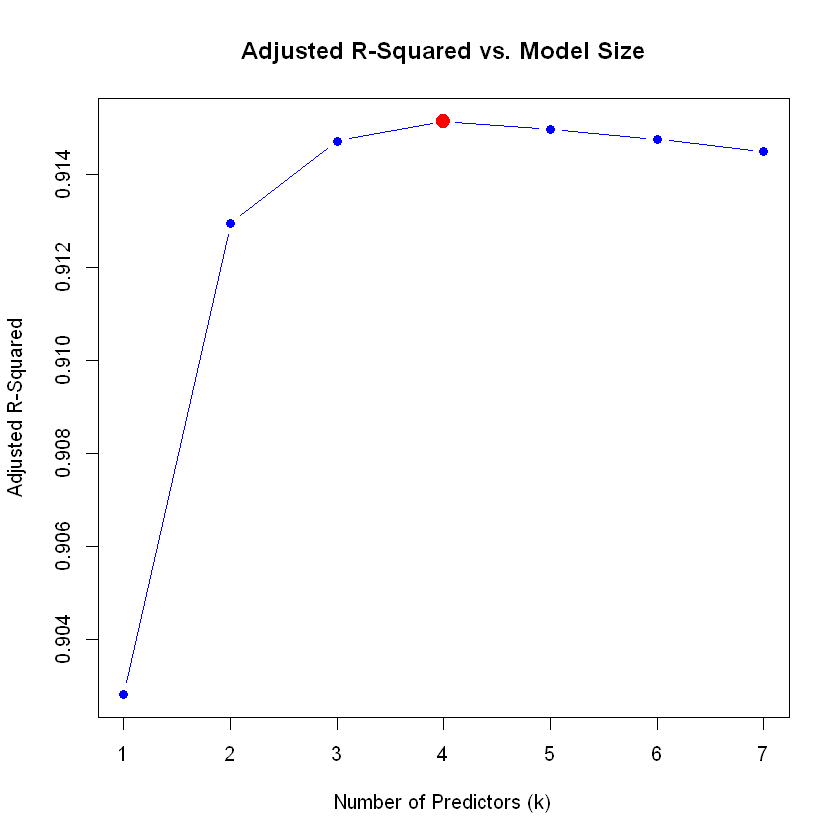

In [80]:
# 7) CODE HERE
# Extract Adjusted R-Squared values
adj_rsq_values <- subset_summary$adjr2  # Adjusted R-squared for each model size

# Find the best model (highest Adjusted R-Squared)
best_k <- which.max(adj_rsq_values)  # Index of the best model

# Display the best model's selected predictors
best_model <- subset_summary$which[best_k, ]
print(best_model)

# Plot Adjusted R-Squared vs. Model Size
plot(1:7, adj_rsq_values, type = "b", pch = 19, col = "blue", xlab = "Number of Predictors (k)", 
     ylab = "Adjusted R-Squared", main = "Adjusted R-Squared vs. Model Size")

# Highlight the best model (highest Adjusted R-Squared)
points(best_k, adj_rsq_values[best_k], col = "red", pch = 19, cex = 1.5)  # Red dot for best model

**PART E:** Compute the MSPE for each of the best models of size $1$, the best model of size $2$, etc. up through the best model of size $7$ (the full model). Which model is best according to this metric? Is this the same model that was selected by MSPE in part B.1 (c)?

You can either fit seven separate models **OR** automate this process in a function with a loop. If you choose to use a loop, consider the following:

1. The function should take in the training set, the test set, and the summary of your `regsubsets()` object (what we called `rs` in class).

2. The function should contain a loop. At step i = 1,...,p of the loop, you should:
    - select the training set model matrix corresponding the the best model of size i. You can do this using the logicals in the table given by `rs$which`.
    
    - fit the regression with the selected model matrix
    
    - select the test set matrix, xstar, of correct size i = 1,...,p. Again, you can do this using the logicals in the table given by `rs$which`.
    
    - compute the predicted value for the selected xstar
    
    - compute the MSPE 

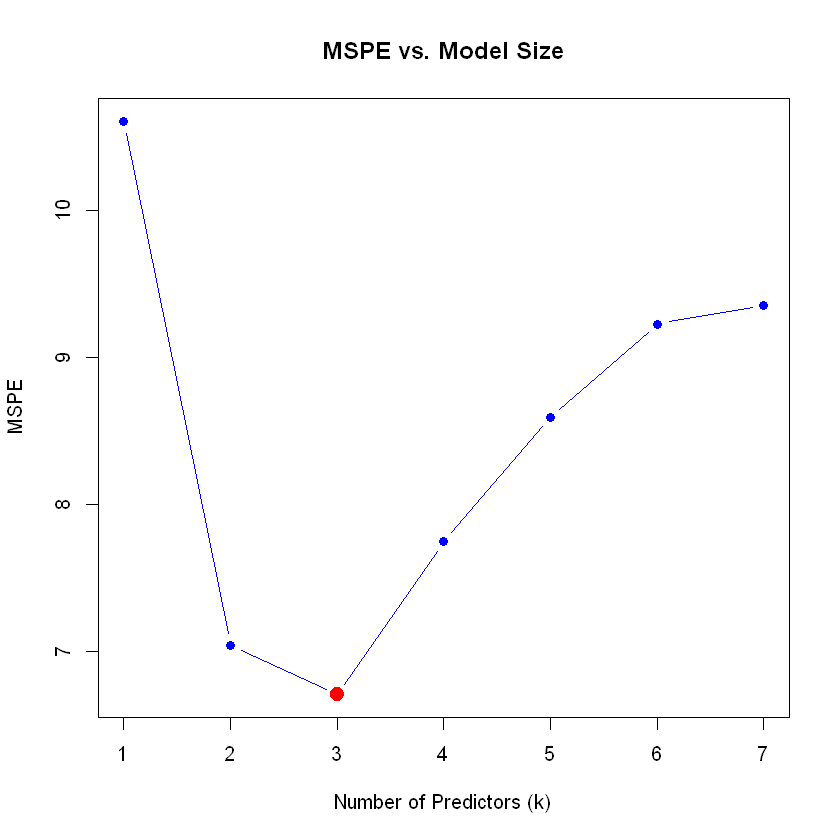

In [84]:
# Initialize vector to store AIC values
mspe_values <- numeric(7)  # Store AIC for each model size

# Loop through model sizes (k = 1 to 7)
for (k in 1:7) {
    # Extract selected predictors for the best model with k predictors
    selected_vars <- names(which(subset_summary$which[k, -1]))  # Exclude intercept
    selected_vars <- gsub("coverP", "cover", selected_vars)
    formula_str <- paste("aprice ~", paste(selected_vars, collapse = " + "))  # Build formula

    # Fit linear model with selected predictors
    model <- lm(as.formula(formula_str), data = train)
    
    # Predict
    y_pred <- predict(model, newdata = X_test)
    
    # Calculate MSPE
    mspe_values[k] <- mse(y_test, y_pred)
}

# Plot AIC vs. Model Size
plot(1:7, mspe_values, type = "b", pch = 19, col = "blue", xlab = "Number of Predictors (k)", 
     ylab = "MSPE", main = "MSPE vs. Model Size")

# Highlight the best model (lowest AIC)
best_k <- which.min(mspe_values)
points(best_k, mspe_values[best_k], col = "red", pch = 19, cex = 1.5)  # Red dot for best model

**Answer**: Model $k=3$ is best according to this model. This model uses the predictors: lprice, thick and cover. The model selected using backward selection uses the following 4 predictors: lprice, pages, weight and cover which is different than the model selected in this Part.

**PART F:** Compute the variance inflation factor for the models selected by AIC, BIC, MSPE, and $R_a^2$. Do any of these models show evidence of collinearity?

In [87]:
# Load the car package for vif function
library(car)

# Assuming subset_summary is already defined
for (k in c(3, 4)) {  # Loop over k = 3 and k = 4
  
  # Select the variables based on the k-th row
  selected_vars <- names(which(subset_summary$which[k, -1]))  # Exclude intercept
  
  # Replace "coverP" with "cover" if it exists in the selected variables
  selected_vars <- gsub("coverP", "cover", selected_vars)
  
  # Build the model formula
  formula_str <- paste("aprice ~", paste(selected_vars, collapse = " + "))  # Build formula
  
  # Fit the linear model with selected predictors
  model <- lm(as.formula(formula_str), data = train)
  
  # Calculate the VIF for the model
  vif_values <- vif(model)
  
  # Print the VIF values
  print(paste("VIF values for k =", k))
  print(vif_values)
}

Loading required package: carData



[1] "VIF values for k = 3"
  lprice    thick    cover 
1.032415 1.163058 1.174192 
[1] "VIF values for k = 4"
  lprice   weight    thick    cover 
1.197162 2.208026 2.036384 1.180699 


All of the VIF values are below 5, which indicates no collinearity concerns in either of the models.
Even the highest VIF value (for weight with a value of 2.208026) is well below the threshold for high collinearity.

## Problem 3 Diagnosing and Correcting Non-Constant Variance (40 points)

Researchers at the National Institutes of Standards and Technology (NIST) collected [pipline data](https://rdrr.io/cran/faraway/man/pipeline.html) on ultrasonic measurements of the depth of defects in the Alaska pipeline in the field. The depths of the defects were then remeasured in the laboratory. The laboratory measurements are more accurate than the field measurements, but more time consuming and expensive. We want to develop a regression model for correcting the in field measurements. 

**PART A:** Fit a regression model where `Lab` is the response and `Field` is the predictor and save this model as `lmodPipeline`. Check for non-constant variance. Use the Pearson residuals. The Pearson residuals are a type of standardized residual. A plot of the Pearson residuals against the fitted values provides evidence of nonconstant variance. You can do this by specifying the "type" argument in your use of the resid function. Note whether or not you see non-constant variance in your plot.

In [88]:
install.packages('faraway', repos='http://cran.us.r-project.org')
library(faraway) #this package contains the pipeline data. 

data(pipeline)
head(pipeline)

Installing package into 'C:/Users/inipo/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'faraway' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\inipo\AppData\Local\Temp\RtmpCGp8Uc\downloaded_packages



Attaching package: 'faraway'


The following objects are masked from 'package:car':

    logit, vif


The following object is masked from 'package:lattice':

    melanoma




,Field,Lab,Batch
,<int>,<dbl>,<fct>
1,18,20.2,1
2,38,56.0,1
3,15,12.5,1
4,20,21.2,1
5,18,15.5,1
6,36,39.0,1


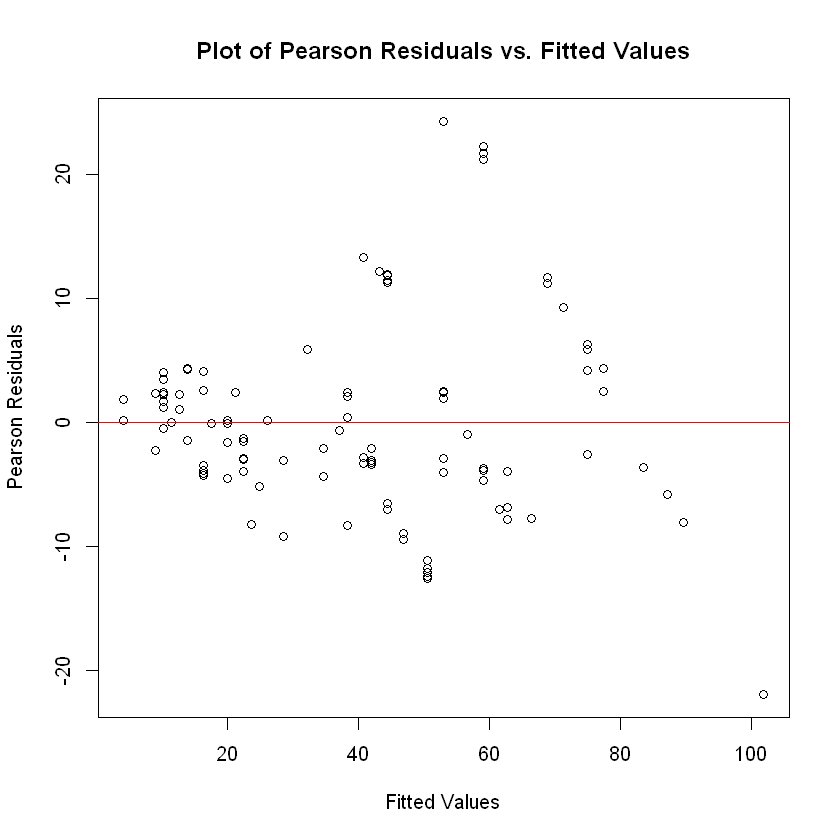

In [90]:
# Fit the regression model
lmodPipeline <- lm(Lab ~ Field, data = pipeline)

# Get the Pearson residuals
pearson_residuals <- resid(lmodPipeline, type = "pearson")

# Plot the Pearson residuals against the fitted values
plot(fitted(lmodPipeline), pearson_residuals, 
     xlab = "Fitted Values", 
     ylab = "Pearson Residuals",
     main = "Plot of Pearson Residuals vs. Fitted Values")

# Add a horizontal line at 0 for reference
abline(h = 0, col = "red")

There might be slight non-constant variance since the residuals gravitates slightly towards $y=0$.

**PART B:** Sometimes transforming the response and predictor helps in stabilizing variance. Find a transformation on Lab and/or Field so that in the transformed scale the relationship is approximately linear with constant variance. Restrict your choice of transformation to square root or log. Save your transformed variables as `pipeline$LabTransform` and `pipeline$FieldTransform`. Then, regress the transformed` Lab` variable (response) onto the transformed `Field` variable (predictor), and save this as `lmodTr`.

Check for non-constant variance in your transformed model using the same process from Part A. What do you notice?

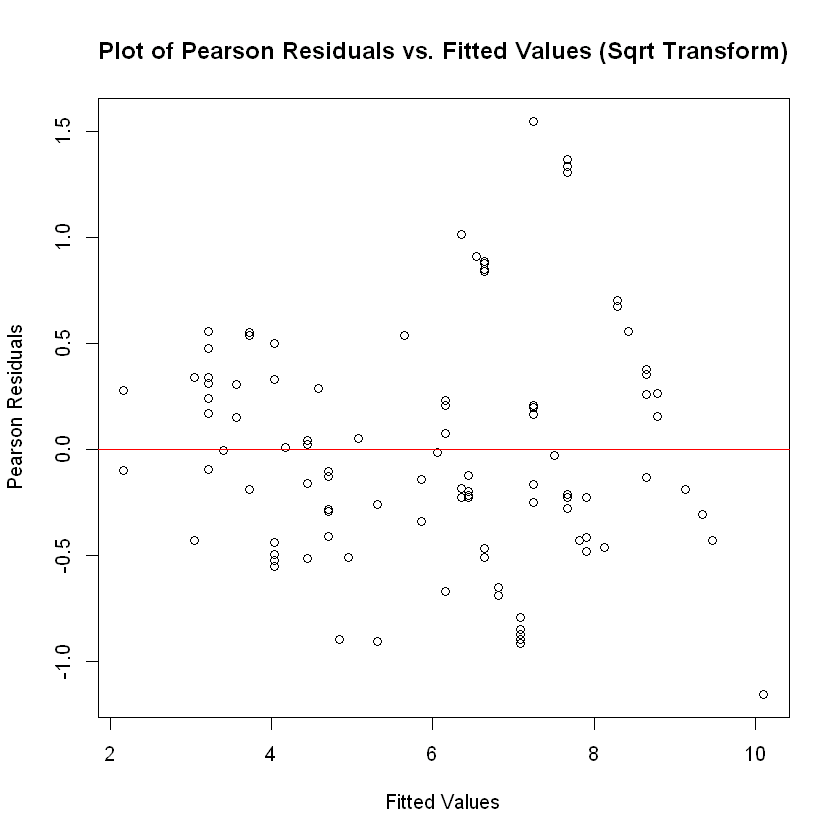

In [94]:
# Apply square root transformation to both Lab and Field
pipeline$LabTransform <- sqrt(pipeline$Lab)  # Square root transformation for Lab
pipeline$FieldTransform <- sqrt(pipeline$Field)  # Square root transformation for Field

# Alternatively, you could try log transformation by uncommenting these lines
# pipeline$LabTransform <- log(pipeline$Lab)
# pipeline$FieldTransform <- log(pipeline$Field)

# Fit the transformed regression model
lmodTr <- lm(LabTransform ~ FieldTransform, data = pipeline)

# Get the Pearson residuals for the transformed model
pearson_residuals_tr <- resid(lmodTr, type = "pearson")

# Plot the Pearson residuals against the fitted values
plot(fitted(lmodTr), pearson_residuals_tr, 
     xlab = "Fitted Values", 
     ylab = "Pearson Residuals",
     main = "Plot of Pearson Residuals vs. Fitted Values (Sqrt Transform)")

# Add a horizontal line at 0 for reference
abline(h = 0, col = "red")


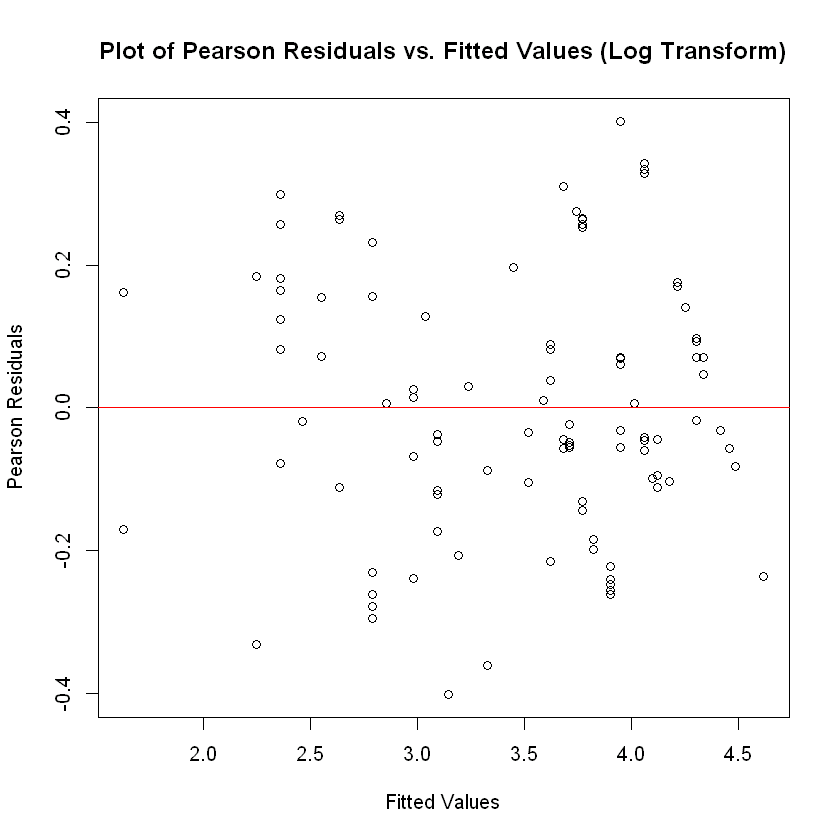

In [93]:
# Apply square root transformation to both Lab and Field
pipeline$LabTransform <- log(pipeline$Lab)  # Square root transformation for Lab
pipeline$FieldTransform <- log(pipeline$Field)  # Square root transformation for Field

# Alternatively, you could try log transformation by uncommenting these lines
# pipeline$LabTransform <- log(pipeline$Lab)
# pipeline$FieldTransform <- log(pipeline$Field)

# Fit the transformed regression model
lmodTr <- lm(LabTransform ~ FieldTransform, data = pipeline)

# Get the Pearson residuals for the transformed model
pearson_residuals_tr <- resid(lmodTr, type = "pearson")

# Plot the Pearson residuals against the fitted values
plot(fitted(lmodTr), pearson_residuals_tr, 
     xlab = "Fitted Values", 
     ylab = "Pearson Residuals",
     main = "Plot of Pearson Residuals vs. Fitted Values (Log Transform)")

# Add a horizontal line at 0 for reference
abline(h = 0, col = "red")


The residuals are much more spread out and the potential pattern in residuals is removed.